In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Librerie + Funzioni

In [ ]:
!pip install sentencepiece
!pip install emoji
!pip install tensorflow_text
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow_text import SentencepieceTokenizer
import tokenization
import string
import re
import numpy as np
import pandas as pd
import emoji
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
!pip install scikit-optimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
from skopt import gp_minimize

In [3]:
def concatenate_info_train(train, fe=[]):
  scaler = MinMaxScaler(feature_range=(0,1))
  pca = PCA(n_components=100, random_state=0)
  X_train = np.array(train["text"].values.tolist())
  X_train = pca.fit_transform(X_train)
  f_scaler = ["emoji", "url", "hashtag", "mention", "len", "upper", "!", "?"]
  f_scaler = [feature for feature in f_scaler if feature in fe]
  if f_scaler:
    X_train = np.hstack([X_train, scaler.fit_transform(train[f_scaler])])
  return X_train, {"pca" : pca, "min-max" : scaler, "features" : f_scaler}

def concatenate_info_test(test, util):
  X_test = np.array(test["text"].values.tolist())
  X_test = util["pca"].transform(X_test)
  if util["features"]:
    X_test = np.hstack([X_test, util["min-max"].transform(test[util["features"]])])
  return X_test

def SVM_Train_test(label, fe, C, gamma):
  X_train, util = concatenate_info_train(train, fe=fe)
  X_test = concatenate_info_test(test, util)
  print("Dim train: %s, Dim test: %s" %(np.shape(X_train), np.shape(X_test)))
  y_train = train[label]
  y_test = test[label]
  clf = SVC(C=C, kernel= "rbf", gamma=gamma, random_state=0)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  return accuracy_score(y_test, y_pred)

# Dati

In [4]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DeepLearningExamples/train_disaster.csv', header = 0, encoding="utf8")
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DeepLearningExamples/test_disaster.csv', header = 0, encoding="utf8")
train = train.drop(columns=['id', 'keyword', 'location'])
test = test.drop(columns=['id', 'keyword', 'location'])
train = train.drop_duplicates().reset_index(drop=True)
train.sample(10, random_state=18)

text  target
7172     A quarter whirlwind. They don't see it coming.       1
6141          @TheTshirtKid I'm tryna smoke that MF out       0
4699  .@dantwitty52 shuts the door on the Boom in th...       0
2895  the future of america #GamerGate http://t.co/U...       0
4392  #hot  C-130 specially modified to land in a st...       1
3492  Monkeys Abused by Notorious Laboratory Dealer ...       0
2439  #???? #?? #??? #??? Trains derailment: 'It's t...       1
3461  Checkout all the NURGLE rules &amp; features t...       0
1178  Two giant cranes holding a bridge collapse int...       1
1557  Photographer Brian Ruebs endures 4500-feet cli...       0

# Estrazione delle informazioni + Preprocessing del testo

In [5]:
# trova il numero di hashtag
def find_hashtag(tweet):
  return len([match.group(0) for match in re.finditer(r"#\w+", tweet)]) or 0

# trova il numero di url
def find_url(tweet):
  return len([match.group(0) for match in re.finditer(r"https?://\S+|www\.\S+", tweet)]) or 0

# trova il numero di menzioni
def find_mention(tweet):
  return len([match.group(0) for match in re.finditer(r"@\w+", tweet)]) or 0

# trova le emoji e le codifica come stringa
def find_emoji(tweet):
  emoji_found = [match.group(0) for match in emoji.get_emoji_regexp().finditer(tweet)]
  emoji_found = [emoji.demojize(e, use_aliases=True, delimiters=("","")) for e in emoji_found]
  emoji_found = ["_".join(e.split("_")[:-3]) if e.endswith("_skin_tone") else e for e in emoji_found ]
  return len(emoji_found) or 0

# rimuove url, hashtag e menzioni dalla frase
def remove_url_hashtage_mention(tweet):
  tweet = re.sub(r"https?://\S+|www\.\S+", "", tweet) # rimuove gli url
  tweet = re.sub(r"#\w+", "", tweet) # rimuove gli hashtag
  tweet = re.sub(r"@\w+", "", tweet) # rimuove le menzioni
  return tweet

# trova il numero di lettere maiuscole nel tweet
def find_upper(tweet):
  return sum(1 for c in remove_url_hashtage_mention(tweet) if c.isupper())

# trova il numero di lettere nel tweet
def find_len(tweet):
  return len(remove_url_hashtage_mention(tweet))

# 0 se ! è presente, 1 altrimenti
def find_exclamative(tweet):
  return 1 if [match.group(0) for match in re.finditer(r"[\!]", remove_url_hashtage_mention(tweet))] else 0

# 0 se ? è presente, 1 altrimenti
def find_interrogative(tweet):
  return 1 if [match.group(0) for match in re.finditer(r"[\?]", remove_url_hashtage_mention(tweet))] else 0

train["emoji"] = train["text"].apply(lambda x: find_emoji(x))
test["emoji"] = test["text"].apply(lambda x: find_emoji(x))

train["url"] = train["text"].apply(lambda x: find_url(x))
test["url"] = test["text"].apply(lambda x: find_url(x))

train["hashtag"] = train["text"].apply(lambda x: find_hashtag(x))
test["hashtag"] = test["text"].apply(lambda x: find_hashtag(x))

train["mention"] = train["text"].apply(lambda x: find_mention(x))
test["mention"] = test["text"].apply(lambda x: find_mention(x))

train["len"] = train["text"].apply(lambda x: find_len(x))
test["len"] = test["text"].apply(lambda x: find_len(x))

train["upper"] = train["text"].apply(lambda x: find_upper(x))
test["upper"] = test["text"].apply(lambda x: find_upper(x))

train["!"] = train["text"].apply(lambda x: find_exclamative(x))
test["!"] = test["text"].apply(lambda x: find_exclamative(x))

train["?"] = train["text"].apply(lambda x: find_interrogative(x))
test["?"] = test["text"].apply(lambda x: find_interrogative(x))

# rimuove in ordine: url, hashtag, menzioni e emoji
def remove_tweet_object(tweet):
  tweet = re.sub(r"https?://\S+|www\.\S+", " ", tweet)
  tweet = re.sub(r"#\w+", " ", tweet)
  tweet = re.sub(r"@\w+", " ", tweet)
  tweet = emoji.get_emoji_regexp().sub(" ", tweet)
  return tweet

def text_filter(tweet):
  tweet = tweet.lower() # porta il testo il lowercase
  tweet = re.sub(r"’", "'", tweet) # trasforma ’ in '
  tweet = remove_tweet_object(tweet) # vengono rimossi: url, hashtag, menzioni e emoji
  return tweet

train["text"] = train["text"].apply(lambda x: text_filter(x))
test["text"] = test["text"].apply(lambda x: text_filter(x))

train.sample(10, random_state=18)

text  target  ...  !  ?
7172     a quarter whirlwind. they don't see it coming.       1  ...  0  0
6141                        i'm tryna smoke that mf out       0  ...  0  0
4699  .  shuts the door on the boom in the bottom ha...       0  ...  0  0
2895                          the future of america           0  ...  0  0
4392     c-130 specially modified to land in a stadi...       1  ...  0  0
3492  monkeys abused by notorious laboratory dealer ...       0  ...  0  0
2439  #???? #?? #??? #??? trains derailment: 'it's t...       1  ...  0  1
3461  checkout all the nurgle rules &amp; features t...       0  ...  1  0
1178  two giant cranes holding a bridge collapse int...       1  ...  0  0
1557  photographer brian ruebs endures 4500-feet cli...       0  ...  0  0

[10 rows x 10 columns]

# Conventional LSTM + Attention

In [34]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train["text"])
train_lstm = tokenizer.texts_to_sequences(train["text"])
test_lstm = tokenizer.texts_to_sequences(test["text"])

train_lstm = keras.preprocessing.sequence.pad_sequences(train_lstm)
test_lstm = keras.preprocessing.sequence.pad_sequences(test_lstm, maxlen=len(train_lstm[0]))
train_lstm

array([[   0,    0,    0, ..., 4287,   86,   36],
       [   0,    0,    0, ..., 6277, 6278, 1538],
       [   0,    0,    0, ..., 1350,   21, 1047],
       ...,
       [   0,    0,    0, ..., 2394,   84, 1297],
       [   0,    0,    0, ...,   65,  649,  198],
       [   0,    0,    0, ...,  193,  786,   84]], dtype=int32)

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, hidden, features):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(features)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [58]:
sequence_input = keras.layers.Input(shape=(len(train_lstm[0]),), dtype="int32")
embedded_sequences = keras.layers.Embedding(len(tokenizer.word_index)+1, 100) (sequence_input)
(out_lstm, forward_h, forward_c, backward_h, backward_c) = keras.layers.Bidirectional(keras.layers.LSTM(8, return_sequences=True, return_state=True))(embedded_sequences)
state_h = keras.layers.Concatenate()([forward_h, backward_h])
context_vector, attention_weights = BahdanauAttention(10) (state_h, out_lstm)
dropout = keras.layers.Dropout(0.5)(context_vector)
output = keras.layers.Dense(2, activation="softmax")(dropout)
  
model = keras.models.Model(inputs=sequence_input, outputs=output)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'],
             )

history_LSTM = model.fit(
    train_lstm,
    train["target"],
    validation_data=(test_lstm, test["target"]),
    epochs=10,
    batch_size=64,
    callbacks=keras.callbacks.EarlyStopping(monitor="val_loss"))

Model: "functional_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 33, 100)      1463700     input_23[0][0]                   
__________________________________________________________________________________________________
bidirectional_26 (Bidirectional [(None, 33, 16), (No 6976        embedding_22[0][0]               
__________________________________________________________________________________________________
concatenate_30 (Concatenate)    (None, 16)           0           bidirectional_26[0][1]           
                                                                 bidirectional_26[0][3

# Universal Sentence Encoder

In [ ]:
tf.random.set_seed(0)

use = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.KerasLayer(use, trainable=False, dtype=tf.string)    

input_text = keras.layers.Input(shape=[], name="Input", dtype=tf.string)
embedding = embed (input_text)
dense = keras.layers.Dropout(0.5) (embedding)
dense = keras.layers.Dense(64, activation='relu')(dense)
dense = keras.layers.Dropout(0.5) (dense)
pred = keras.layers.Dense(2, activation='softmax')(dense)
model = keras.models.Model(inputs=[input_text], outputs=pred)

model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'],
             )

model.summary()

history_USE = model.fit(
    train["text"],
    train["target"],
    validation_data=(test["text"], test["target"]),
    epochs=4,
    batch_size=64,
    callbacks=keras.callbacks.EarlyStopping(monitor="val_loss"))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None,)]                 0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 147,387,842
Trainable params: 32,962
Non-trainable params: 147,354,880
________________________________________

# Universal Sentence Encoder feature extraction + SVM

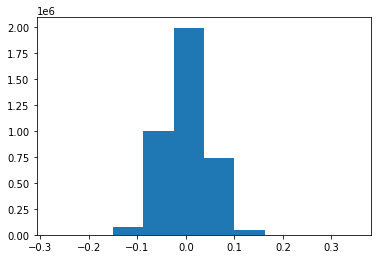

text  target  ...  !  ?
7172  [0.07643340528011322, 0.07896124571561813, -0....       1  ...  0  0
6141  [0.0357528030872345, -0.0013407592196017504, -...       0  ...  0  0
4699  [0.07990807294845581, 0.0524296835064888, -0.0...       0  ...  0  0
2895  [0.01627284102141857, -0.03539872169494629, 0....       0  ...  0  0
4392  [-0.03610589727759361, -0.028754407539963722, ...       1  ...  0  0
3492  [-0.018424995243549347, 0.046201545745134354, ...       0  ...  0  0
2439  [0.07401835173368454, 0.018313953652977943, -0...       1  ...  0  1
3461  [0.04834817349910736, -0.05239087715744972, 0....       0  ...  1  0
1178  [0.036510251462459564, -0.01844530738890171, 0...       1  ...  0  0
1557  [-0.060067277401685715, 0.03984897583723068, 0...       0  ...  0  0

[10 rows x 10 columns]

In [ ]:
tf.random.set_seed(0)

use = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.KerasLayer(use, trainable=False, dtype=tf.string)  

train["text"] = embed(train["text"]).numpy().tolist()
test["text"] = embed(test["text"]).numpy().tolist()

dist = [j for i in train.text for j in i]
plt.hist(dist)
plt.show()

train.sample(10, random_state=18)

In [ ]:
label = "target"

C = 2.2002243367354755
gamma = 0.9383577086451415
feature = ['url', 'hashtag', 'len', 'upper']

result = SVM_Train_test(label, feature, C, gamma)
print("----Risultati sul test----")
print("Accuracy: %s" % result)

Dim train: (7521, 104), Dim test: (3263, 104)
----Risultati sul test----
Accuracy: 0.827459393196445


In [ ]:
%%time
space = [Real(1e-1, 1e+5, prior="log-uniform", name="C_opt", transform="normalize"),
         Real(1e-5, 1e+1, prior="log-uniform", name="gamma_opt", transform="normalize"),
         Integer(0, 1, name="emoji_opt", transform="normalize"),
         Integer(0, 1, name="url_opt", transform="normalize"),
         Integer(0, 1, name="hashtag_opt", transform="normalize"),
         Integer(0, 1, name="mention_opt", transform="normalize"),
         Integer(0, 1, name="len_opt", transform="normalize"),
         Integer(0, 1, name="upper_opt", transform="normalize"),
         Integer(0, 1, name="exclamative_opt", transform="normalize"),
         Integer(0, 1, name="iterrogative_opt", transform="normalize")]

@use_named_args(space)
def opt_model(C_opt, gamma_opt, emoji_opt, url_opt, hashtag_opt, mention_opt, 
              len_opt, upper_opt, exclamative_opt, iterrogative_opt):
  dev_train, dev_test = train, test
  y_train, y_test = train[label], test[label]

  X_train = np.array(dev_train["text"].values.tolist())
  X_test = np.array(dev_test["text"].values.tolist())

  f_scaler = []
  if int(emoji_opt) == 1:
    f_scaler.append("emoji")
  if int(url_opt) == 1:
    f_scaler.append("url")
  if int(hashtag_opt) == 1:
    f_scaler.append("hashtag")
  if int(mention_opt) == 1:
    f_scaler.append("mention")
  if int(len_opt) == 1:
    f_scaler.append("len")
  if int(upper_opt) == 1:
    f_scaler.append("upper")
  if int(exclamative_opt) == 1:
    f_scaler.append("!")
  if int(iterrogative_opt) == 1:
    f_scaler.append("?")
  if f_scaler:
    X_train = np.hstack([X_train, scaler.fit_transform(dev_train[f_scaler])])
    X_test = np.hstack([X_test, scaler.transform(dev_test[f_scaler])])

  clf.set_params(**{"C":C_opt,"gamma":gamma_opt})
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  return -accuracy_score(y_test, y_pred)

label = "target"
pca = PCA(n_components=100, random_state=0)
train["text"] = pca.fit_transform(train["text"].values.tolist()).tolist()
test["text"] = pca.transform(test["text"].values.tolist()).tolist()
clf = SVC(kernel= "rbf")
scaler = MinMaxScaler(feature_range=(0, 1))
res = gp_minimize(opt_model, space, n_random_starts=10, n_calls=100, n_jobs=-1, verbose=1, random_state=0)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.5871
Function value obtained: -0.7898
Current minimum: -0.7898
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.3536
Function value obtained: -0.8180
Current minimum: -0.8180
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.9636
Function value obtained: -0.7787
Current minimum: -0.8180
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.1404
Function value obtained: -0.8072
Current minimum: -0.8180
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.4330
Function value obtained: -0.8121
Current minimum: -0.8180
Iteration No: 6 start

[2.2002243367354755, 0.9383577086451415, 0, 1, 1, 0, 1, 1, 0, 0]
Best parameters:
C = 2.2002243367354755
gamma = 0.9383577086451415
feature = ['url', 'hashtag', 'len', 'upper']
-0.827459393196445


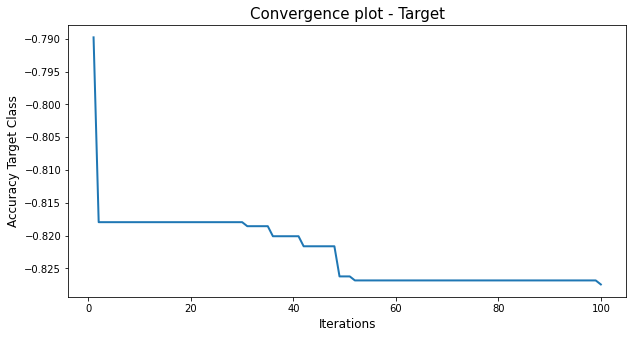

In [ ]:
print(res.x)
f = []
for i in zip(res.x[2:], ["emoji", "url", "hashtag", "mention", "len", "upper", "!", "?"]):
  if i[0] != 0:
    f.append(i[1])
print("""Best parameters:
C = %s
gamma = %s
feature = %s""" % (res.x[0], res.x[1], f))
print(res.fun)
plt.figure(figsize = (10, 5))
mins = [np.min(res.func_vals[:i]) for i in range(1, len(res.x_iters) + 1)]
plt.plot(range(1, len(res.x_iters) + 1), mins, lw=2)
plt.title("Convergence plot - "+ label.title(), fontsize = 15)
plt.ylabel("Accuracy "+ label.title() + " Class", fontsize = 12)
plt.xlabel("Iterations", fontsize = 12)
plt.show()

# BERT

In [ ]:
def sentence_len(train, test, tokenizer):
  max_train = 0
  for i in train["text"]:
    m = np.shape(tokenizer.tokenize(i))[0]
    if m > max_train:
      max_train = m
  max_test = 0
  for i in test["text"]:
    m = np.shape(tokenizer.tokenize(i))[0]
    if m > max_test:
      max_test = m
  return np.max([max_train, max_test])

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
max_len = sentence_len(train, test, tokenizer)

train_input = bert_encode(train["text"].values, tokenizer, max_len=max_len)
test_input = bert_encode(test["text"].values, tokenizer, max_len=max_len)

input_word_ids = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
drop = keras.layers.Dropout(0.5) (pooled_output)
out = keras.layers.Dense(2, activation='softmax')(drop)

model = keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.compile(keras.optimizers.Adam(lr=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

model.summary()

history_bert = model.fit(
    train_input, 
    train["target"],
    validation_data=(test_input, test["target"]),
    epochs = 2,
    batch_size = 32
    )

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 76)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 76)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 76)]         0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
accuracy_score(test["target"], np.asarray(model.predict(test_input)).argmax(axis=-1))

0.8348145878026356

# BERT feature extraction + SVM

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 76)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 76)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 76)]         0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

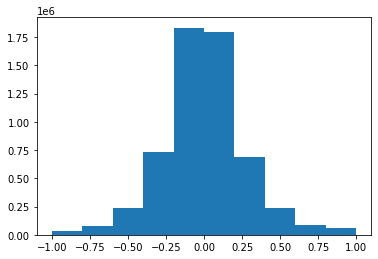

text  target  ...  !  ?
7172  [0.07699090242385864, 0.0914669930934906, -0.0...       1  ...  0  0
6141  [0.09926208853721619, 0.01617458648979664, -0....       0  ...  0  0
4699  [0.1295638531446457, 0.09881826490163803, -0.1...       0  ...  0  0
2895  [-0.234247624874115, -0.05886317044496536, -0....       0  ...  0  0
4392  [0.21415986120700836, 0.14972640573978424, 0.7...       1  ...  0  0
3492  [0.18014928698539734, -0.055821456015110016, -...       0  ...  0  0
2439  [0.22590422630310059, 0.09355312585830688, 0.0...       1  ...  0  1
3461  [0.09841074794530869, -0.043487321585416794, -...       0  ...  1  0
1178  [-0.2137863039970398, 0.06370629370212555, 0.1...       1  ...  0  0
1557  [0.02028614655137062, -0.06283268332481384, -0...       0  ...  0  0

[10 rows x 10 columns]

In [ ]:
bert_enc = bert_layer([input_word_ids, input_mask, segment_ids])
model_bert_enc = keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=bert_enc)
model_bert_enc.summary()
train["text"] = model_bert_enc.predict(train_input)[0].tolist()
test["text"] = model_bert_enc.predict(test_input)[0].tolist()

dist = [j for i in train.text for j in i]
plt.hist(dist)
plt.show()

train.sample(10, random_state=18)

In [ ]:
label = "target"

C = 100000.0
gamma = 1.4154878511734344e-05
feature = ['emoji', 'url', 'len', '?']

result = SVM_Train_test(label, feature, C, gamma)
print("----Risultati sul test----")
print("Accuracy: %s" % result)

Dim train: (7521, 104), Dim test: (3263, 104)
----Risultati sul test----
Accuracy: 0.8366533864541833


In [ ]:
%%time
space = [Real(1e-1, 1e+5, prior="log-uniform", name="C_opt", transform="normalize"),
         Real(1e-5, 1e+1, prior="log-uniform", name="gamma_opt", transform="normalize"),
         Integer(0, 1, name="emoji_opt", transform="normalize"),
         Integer(0, 1, name="url_opt", transform="normalize"),
         Integer(0, 1, name="hashtag_opt", transform="normalize"),
         Integer(0, 1, name="mention_opt", transform="normalize"),
         Integer(0, 1, name="len_opt", transform="normalize"),
         Integer(0, 1, name="upper_opt", transform="normalize"),
         Integer(0, 1, name="exclamative_opt", transform="normalize"),
         Integer(0, 1, name="iterrogative_opt", transform="normalize")]

@use_named_args(space)
def opt_model(C_opt, gamma_opt, emoji_opt, url_opt, hashtag_opt, mention_opt, 
              len_opt, upper_opt, exclamative_opt, iterrogative_opt):
  dev_train, dev_test = train, test
  y_train, y_test = train[label], test[label]

  X_train = np.array(dev_train["text"].values.tolist())
  X_test = np.array(dev_test["text"].values.tolist())

  f_scaler = []
  if int(emoji_opt) == 1:
    f_scaler.append("emoji")
  if int(url_opt) == 1:
    f_scaler.append("url")
  if int(hashtag_opt) == 1:
    f_scaler.append("hashtag")
  if int(mention_opt) == 1:
    f_scaler.append("mention")
  if int(len_opt) == 1:
    f_scaler.append("len")
  if int(upper_opt) == 1:
    f_scaler.append("upper")
  if int(exclamative_opt) == 1:
    f_scaler.append("!")
  if int(iterrogative_opt) == 1:
    f_scaler.append("?")
  if f_scaler:
    X_train = np.hstack([X_train, scaler.fit_transform(dev_train[f_scaler])])
    X_test = np.hstack([X_test, scaler.transform(dev_test[f_scaler])])

  clf.set_params(**{"C":C_opt,"gamma":gamma_opt})
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  return -accuracy_score(y_test, y_pred)

label = "target"
pca = PCA(n_components=100, random_state=0)
train["text"] = pca.fit_transform(train["text"].values.tolist()).tolist()
test["text"] = pca.transform(test["text"].values.tolist()).tolist()
clf = SVC(kernel= "rbf")
scaler = MinMaxScaler(feature_range=(0, 1))
res = gp_minimize(opt_model, space, n_random_starts=10, n_calls=100, n_jobs=-1, verbose=1, random_state=0)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.7219
Function value obtained: -0.6485
Current minimum: -0.6485
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.7437
Function value obtained: -0.7830
Current minimum: -0.7830
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.3521
Function value obtained: -0.7806
Current minimum: -0.7830
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.6843
Function value obtained: -0.8262
Current minimum: -0.8262
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.3060
Function value obtained: -0.6387
Current minimum: -0.8262
Iteration No: 6 star

[100000.0, 1.4154878511734344e-05, 1, 1, 0, 0, 1, 0, 0, 1]
Best parameters:
C = 100000.0
gamma = 1.4154878511734344e-05
feature = ['emoji', 'url', 'len', '?']
-0.8366533864541833


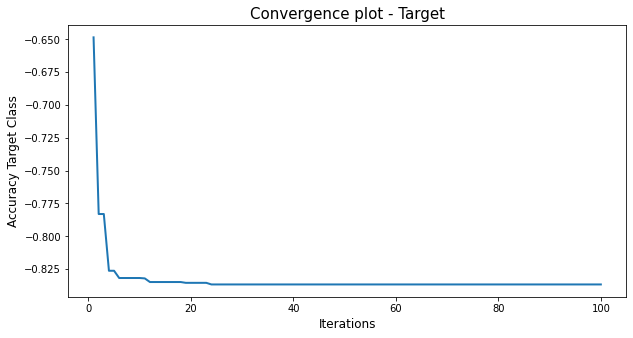

In [ ]:
print(res.x)
f = []
for i in zip(res.x[2:], ["emoji", "url", "hashtag", "mention", "len", "upper", "!", "?"]):
  if i[0] != 0:
    f.append(i[1])
print("""Best parameters:
C = %s
gamma = %s
feature = %s""" % (res.x[0], res.x[1], f))
print(res.fun)
plt.figure(figsize = (10, 5))
mins = [np.min(res.func_vals[:i]) for i in range(1, len(res.x_iters) + 1)]
plt.plot(range(1, len(res.x_iters) + 1), mins, lw=2)
plt.title("Convergence plot - "+ label.title(), fontsize = 15)
plt.ylabel("Accuracy "+ label.title() + " Class", fontsize = 12)
plt.xlabel("Iterations", fontsize = 12)
plt.show()